#TravelTide - Customer Segmentation & Perk Strategy (Public Version)
#  ---------------------------------------------------------------
This public notebook loads a sample dataset and reproduces the key visualizations:  
- PCA Scree Plot  
- Cluster Profile Heatmap  
- Simulated Booking Rate per Perk  
No database access is required.

# 1. Setup & Libraries

In [1]:
!pip install hdbscan --quiet

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
import os

sns.set(style="whitegrid", palette="Blues_r")
plt.rcParams["figure.dpi"] = 120


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


#2. Load Processed Dataset

In [3]:
DATA_PATH = "Finale_Cluster_Analyse.csv"
df = pd.read_csv(DATA_PATH)

print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
print(df.head())

Data loaded successfully: 1223 rows, 11 columns
      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5  cluster  cluster_grouped  \
0  1.076362  7.106032  0.229096 -0.000882  7.612969       28               28   
1  3.133823 -0.752837 -4.457762 -1.221496  4.964000       26               26   
2  2.683498 -0.259322 -4.047207 -1.583466  5.674905       26               26   
3  4.619043 -1.427760 -4.759328 -1.725631  4.172406       26               26   
4  3.315454 -1.466008 -4.351928 -2.182439  4.952521       26               26   

        cluster_typ                   assigned_perk  buchung  perk_encoded  
0       Vielflieger                Free Checked Bag        0             2  
1  Premium-Reisende  1 Night Free Hotel with Flight        0             0  
2  Premium-Reisende  1 Night Free Hotel with Flight        1             0  
3  Premium-Reisende  1 Night Free Hotel with Flight        0             0  
4  Premium-Reisende  1 Night Free Hotel with Flight        1             0  


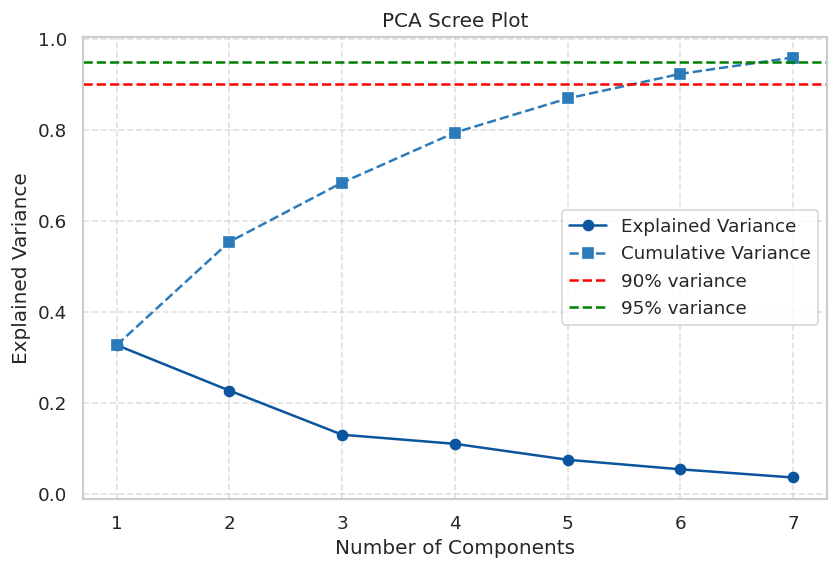

In [4]:
# ========== 3. PCA Scree Plot ==========

pca_features = [col for col in df.columns if col.startswith("PCA_")]
if len(pca_features) >= 5:
    explained_variance = np.array([0.327, 0.227, 0.130, 0.110, 0.075, 0.054, 0.036])
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Explained Variance')
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='--', label='Cumulative Variance')
    plt.axhline(y=0.9, color='r', linestyle='dashed', label="90% variance")
    plt.axhline(y=0.95, color='g', linestyle='dashed', label="95% variance")
    plt.title("PCA Scree Plot")
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.savefig("pca_scree.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("PCA columns not found; skipping Scree plot.")


#4. Cluster Size Plot

In [ ]:
if "cluster" in df.columns:
    cluster_counts = df["cluster"].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values)
    plt.title("Cluster Sizes (including noise -1)")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Customers")
    plt.xticks(rotation=45, ha="right")
    plt.savefig("cluster_sizes.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("Column 'cluster' not found; skipping cluster size plot.")


#5. Cluster Mapping & Heatmap

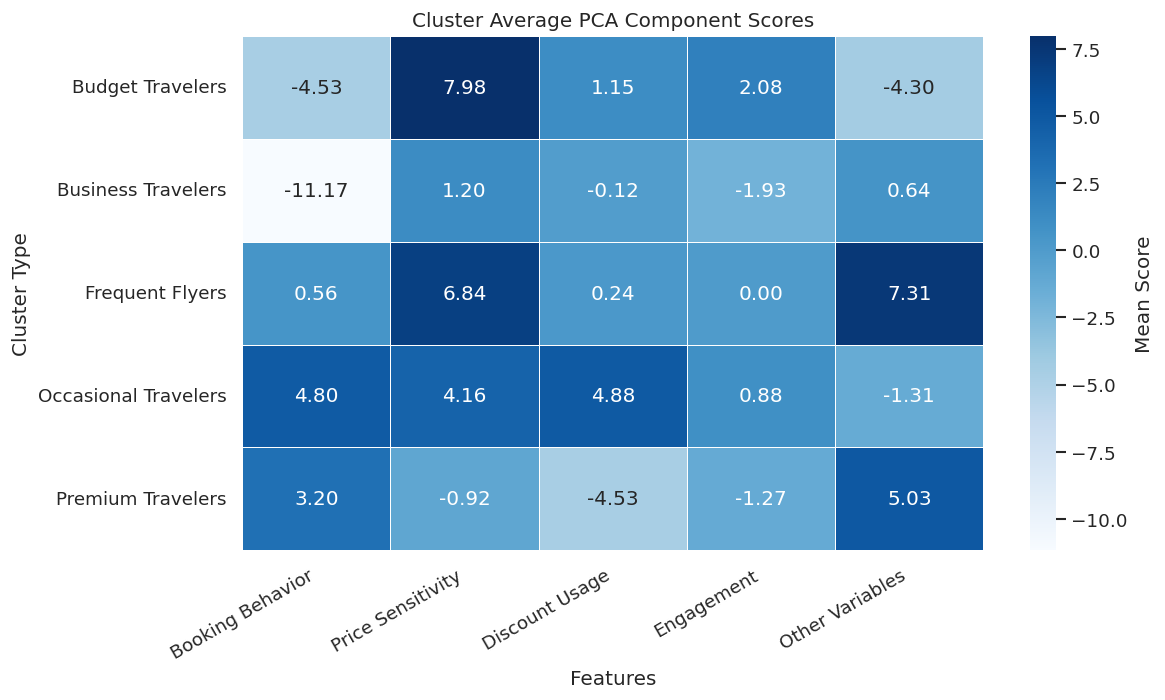

In [5]:
cluster_mapping = {
    -1: "Unclear Data",
    28: "Frequent Flyers",
    34: "Business Travelers",
    16: "Budget Travelers",
    26: "Premium Travelers",
    57: "Occasional Travelers",
}

df["cluster_typ"] = df["cluster"].map(cluster_mapping).fillna("Unknown")

pca_mapping = {
    "PCA_1": "Booking Behavior",
    "PCA_2": "Price Sensitivity",
    "PCA_3": "Discount Usage",
    "PCA_4": "Engagement",
    "PCA_5": "Other Variables",
}

heatmap_data = df.groupby("cluster_typ")[pca_features].mean()
heatmap_data.rename(columns=pca_mapping, inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Mean Score'}
)
plt.title("Cluster Average PCA Component Scores")
plt.xlabel("Features")
plt.ylabel("Cluster Type")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("heatmap_clusterwerte.png", dpi=300, bbox_inches="tight")
plt.show()


#6. Perk Assignment Visualization

In [ ]:
perk_mapping = {
    "Frequent Flyers": "Free Checked Bag",
    "Business Travelers": "No Cancellation Fees",
    "Budget Travelers": "Exclusive Discounts",
    "Premium Travelers": "1 Night Free Hotel with Flight",
    "Occasional Travelers": "Free Hotel Meal",
    "Unclear Data": "Unknown",
}

df["assigned_perk"] = df["cluster_typ"].map(perk_mapping).fillna("Unknown")
df = df[df["assigned_perk"] != "Unknown"]

perk_counts = df["assigned_perk"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=perk_counts.index, y=perk_counts.values)
plt.title("Number of Customers per Perk")
plt.xlabel("Perk Type")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("anzahl_kunden_pro_perk.png", dpi=300, bbox_inches="tight")
plt.show()


#7. Simulated Booking Rate per Perk

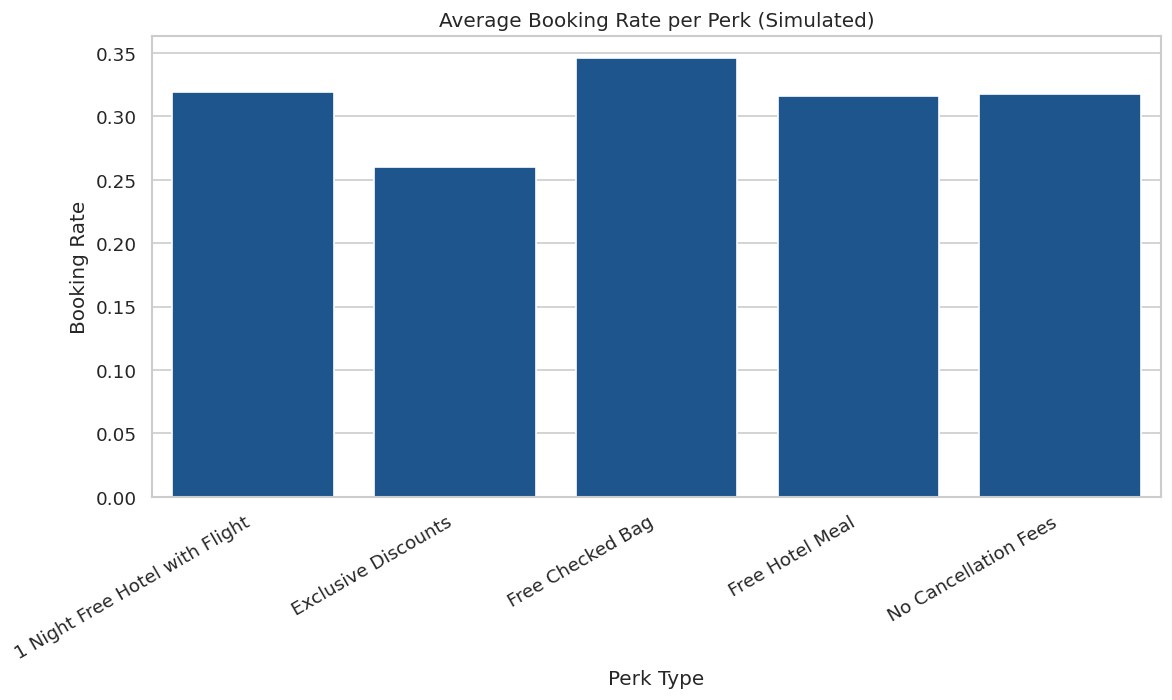

In [18]:
df["buchung"] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])
perk_booking_rates = df.groupby("assigned_perk")["buchung"].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=perk_booking_rates.index, y=perk_booking_rates.values)
plt.title("Average Booking Rate per Perk (Simulated)")
plt.xlabel("Perk Type")
plt.ylabel("Booking Rate")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig("buchungsrate_pro_perk.png", dpi=300, bbox_inches="tight")
plt.show()
